<a href="https://colab.research.google.com/github/lisaong/stackup-workshops/blob/master/mask-or-not/mask_or_not.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [353]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
import pickle

In [132]:
!wget -q https://github.com/lisaong/stackup-workshops/raw/master/mask-or-not/data.zip -O data.zip
!unzip -o data.zip

Archive:  data.zip
  inflating: data/mask/1.jpg         
  inflating: data/mask/10.jpg        
  inflating: data/mask/2.jpg         
  inflating: data/mask/3.jpg         
  inflating: data/mask/4.jpg         
  inflating: data/mask/5.jpg         
  inflating: data/mask/6.jpg         
  inflating: data/mask/7.jpg         
  inflating: data/mask/8.jpg         
  inflating: data/mask/9.jpg         
  inflating: data/no_mask/1.jpg      
  inflating: data/no_mask/10.jpg     
  inflating: data/no_mask/2.jpg      
  inflating: data/no_mask/3.jpg      
  inflating: data/no_mask/4.jpg      
  inflating: data/no_mask/5.jpg      
  inflating: data/no_mask/6.jpg      
  inflating: data/no_mask/7.jpg      
  inflating: data/no_mask/8.jpg      
  inflating: data/no_mask/9.jpg      


In [147]:
# https://pythonprogramming.net/haar-cascade-face-eye-detection-python-opencv-tutorial/
# https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html
face_cascade = cv2.CascadeClassifier(f'{cv2.data.haarcascades}haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(f'{cv2.data.haarcascades}haarcascade_eye.xml')

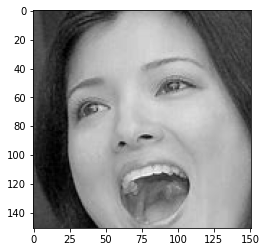

In [148]:
def detect(detector, path):
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = detector.detectMultiScale(img)

  for (x,y,w,h) in faces:
    face = img[y:y+h, x:x+w]
    plt.imshow(face, cmap='gray')
    plt.show()
  
detect(face_cascade, './data/no_mask/1.jpg')

In [149]:
detect(face_cascade, './data/mask/1.jpg')

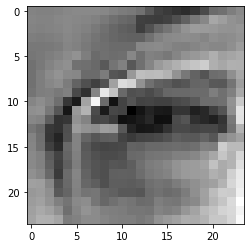

In [150]:
detect(eye_cascade, './data/mask/1.jpg')

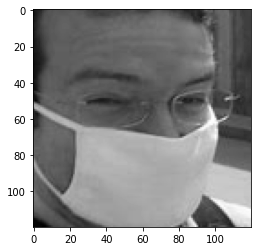

In [161]:
def crop_face(detector, eye_detector, path, output_size=(120, 120)):
  img = cv2.imread(path)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  height, width, channels = img.shape

  # use the colour version for detection, but the
  # grayscale version for result
  faces = detector.detectMultiScale(img)
  eyes = eye_detector.detectMultiScale(img)

  face = None
  if len(faces) > 0:
    x,y,w,h = faces[0]
    face = gray[y:y+h, x:x+w]
  elif len(eyes) > 0:
    # mask is stumping haar face detection
    # approximate face by detecting the left eye
    x,y,w,h = eyes[0]
    # approximate face dimensions using the
    # left eye as reference
    face = gray[max(0, y-2*h):min(y+4*h, height), 
                max(0, x-3*w):min(x+2*w, width)]
  else:
    # nothing detected, just return original image
    face = gray

  face = cv2.resize(face, output_size)
  plt.imshow(face, cmap='gray')
  plt.show()
  return face

crop_face(face_cascade, eye_cascade, './data/mask/1.jpg');

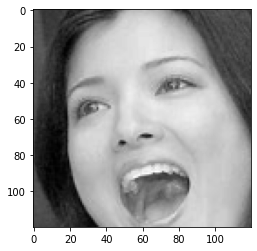

In [162]:
crop_face(face_cascade, eye_cascade, './data/no_mask/1.jpg');

10.jpg


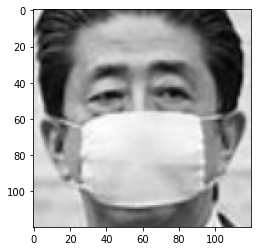

3.jpg


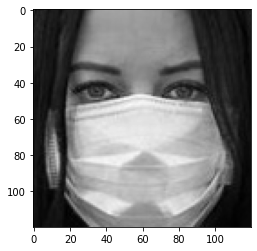

8.jpg


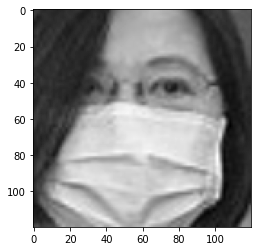

4.jpg


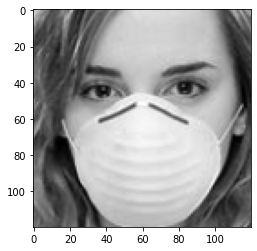

2.jpg


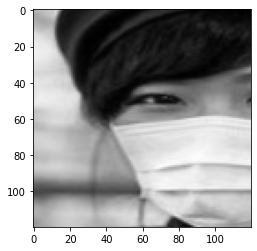

9.jpg


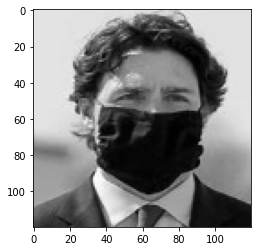

6.jpg


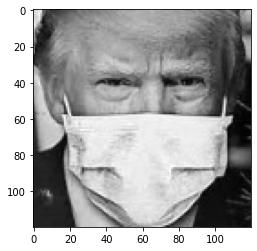

7.jpg


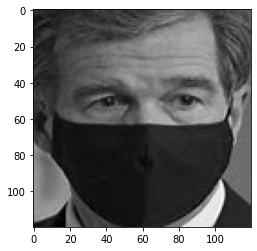

1.jpg


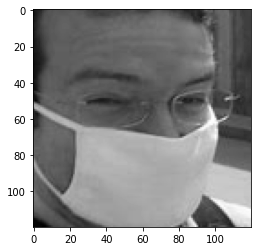

5.jpg


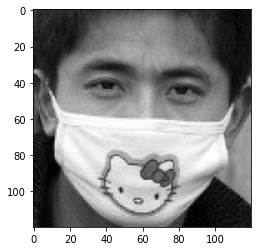

(10, 120, 120)

In [163]:
def get_image_data(label):
  images = []
  for path in Path(f'./data/{label}').rglob('*.jpg'):
    print(path.name)
    images.append(np.array(crop_face(face_cascade, eye_cascade, f'./data/{label}/{path.name}')))
  return np.array(images)

images_mask = get_image_data('mask')
images_mask.shape

10.jpg


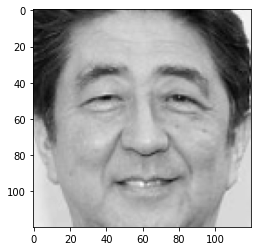

3.jpg


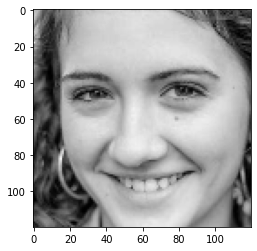

8.jpg


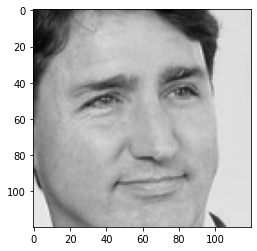

4.jpg


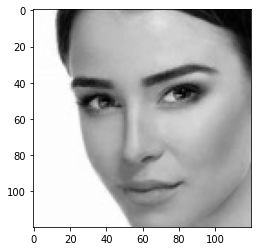

2.jpg


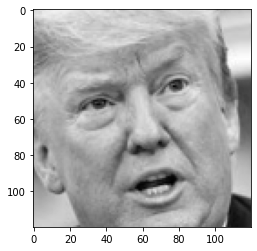

9.jpg


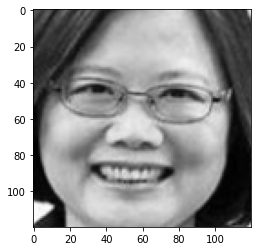

6.jpg


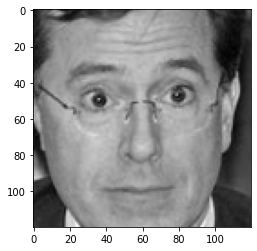

7.jpg


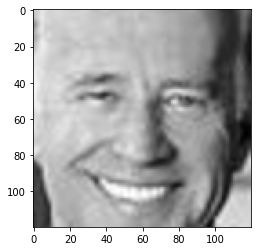

1.jpg


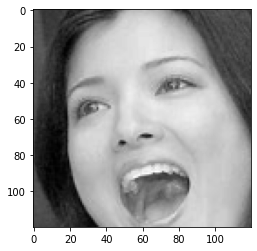

5.jpg


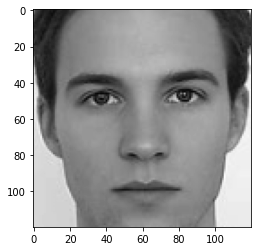

(10, 120, 120)

In [164]:
images_nomask = get_image_data('no_mask')
images_nomask.shape

In [168]:
labels = ['nomask'] * images_nomask.shape[0] + ['mask'] * images_mask.shape[0]
labels

['nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'nomask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask',
 'mask']

In [172]:
images = np.vstack([images_nomask, images_mask])
images.shape

(20, 120, 120)

In [180]:
# flatten
X = images.reshape(-1, images.shape[1]*images.shape[2])
X.shape

(20, 14400)

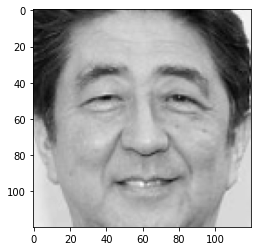

In [181]:
# can we get it back?
plt.imshow(X[0].reshape(images.shape[1], images.shape[2]), cmap='gray')
plt.show()

In [355]:
pca = PCA(n_components=.95)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# tune PCA
pca.fit(X_scaled)

pca.explained_variance_ratio_

array([0.23554452, 0.16208076, 0.14761428, 0.09502714, 0.05491464,
       0.05454585, 0.03296292, 0.03141377, 0.03011283, 0.02454523,
       0.02304494, 0.01897599, 0.01718358, 0.0163146 , 0.01363545])

In [356]:
np.arange(1, pca.n_components_+1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

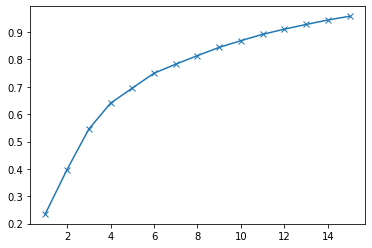

In [357]:
plt.plot(np.arange(1, pca.n_components_+1), pca.explained_variance_ratio_.cumsum(), marker='x')
plt.show()

In [359]:
# choose 5 features, since we only have 20 rows
pca = PCA(n_components=5)
Z = pca.fit_transform(X_scaled)

In [360]:
# let's do a pairplot
df = pd.DataFrame(Z)
df['label'] = labels
df.head()

0           1          2          3          4   label
0 -24.976307   38.775840 -19.533162 -37.042755  -7.163402  nomask
1 -20.308183   10.956034 -44.230523  11.355044 -25.201725  nomask
2   0.386405   55.004818  -8.397229 -28.469491 -54.757781  nomask
3  -0.764470  102.778799  10.273023 -28.399712  60.283189  nomask
4  29.480120   48.805934 -26.222703   6.992940 -14.642122  nomask

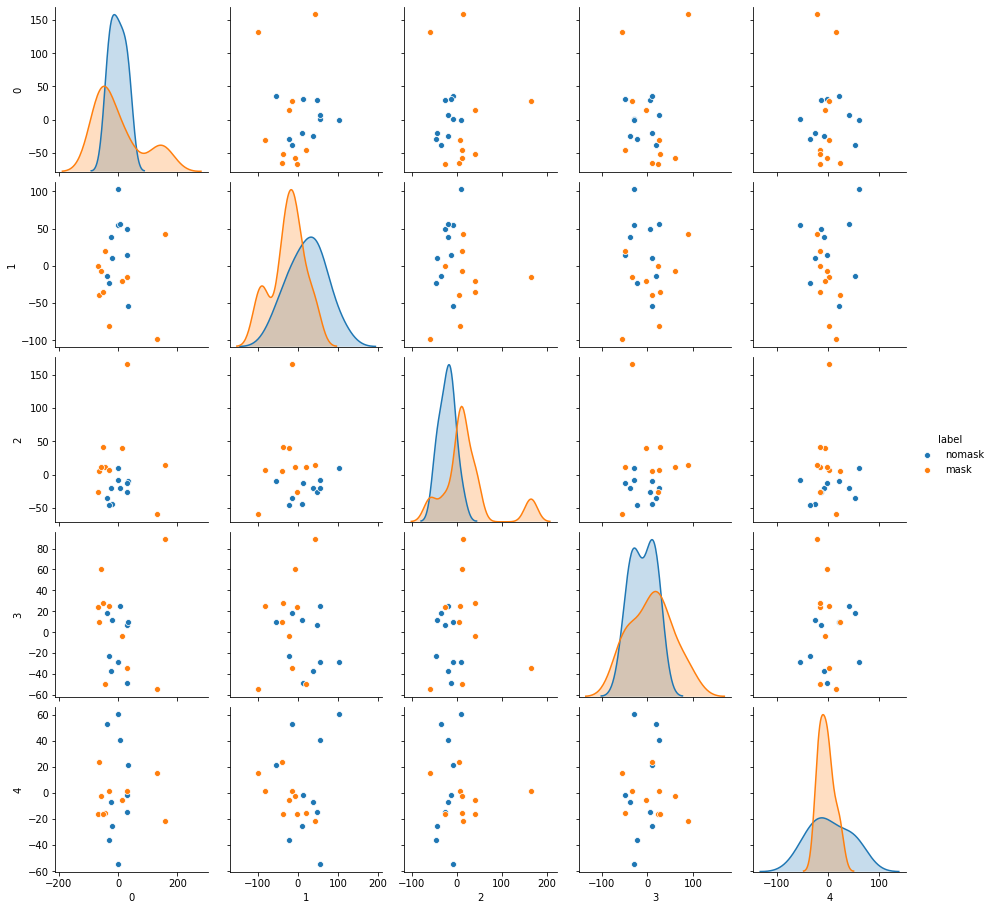

In [361]:
sns.pairplot(df, hue='label')

In [362]:
le = LabelEncoder()
y = le.fit_transform(labels)

In [363]:
X_train, X_test, y_train, y_test = train_test_split(Z, y, random_state=1, stratify=y)

In [364]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.8

In [365]:
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.67      0.80         3

    accuracy                           0.80         5
   macro avg       0.83      0.83      0.80         5
weighted avg       0.87      0.80      0.80         5



## Neural Networks

In [371]:
from tensorflow.keras import layers

mlp = tf.keras.Sequential()
mlp.add(layers.Dense(X_train.shape[1], input_shape=(X_train.shape[1],), activation='relu'))
mlp.add(layers.Dense(X_train.shape[1], activation='relu'))
mlp.add(layers.Dense(1, activation='sigmoid'))
mlp.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_93 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_94 (Dense)             (None, 1)                 6         
Total params: 66
Trainable params: 66
Non-trainable params: 0
_________________________________________________________________


In [372]:
mlp.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
history = mlp.fit(X_train, y_train, batch_size=5, epochs=100,
                  validation_data=(X_test, y_test))

Epoch 1/100
3/3 [==============================] - 0s 34ms/step - loss: 1.1715 - accuracy: 0.8000 - val_loss: 6.7424 - val_accuracy: 0.6000
Epoch 2/100
3/3 [==============================] - 0s 10ms/step - loss: 1.0921 - accuracy: 0.8667 - val_loss: 6.6177 - val_accuracy: 0.6000
Epoch 3/100
3/3 [==============================] - 0s 9ms/step - loss: 1.0409 - accuracy: 0.8667 - val_loss: 6.4871 - val_accuracy: 0.6000
Epoch 4/100
3/3 [==============================] - 0s 10ms/step - loss: 0.9781 - accuracy: 0.8667 - val_loss: 6.3589 - val_accuracy: 0.6000
Epoch 5/100
3/3 [==============================] - 0s 9ms/step - loss: 0.9239 - accuracy: 0.8667 - val_loss: 6.2010 - val_accuracy: 0.6000
Epoch 6/100
3/3 [==============================] - 0s 9ms/step - loss: 0.8717 - accuracy: 0.8667 - val_loss: 6.0465 - val_accuracy: 0.6000
Epoch 7/100
3/3 [==============================] - 0s 10ms/step - loss: 0.8253 - accuracy: 0.8667 - val_loss: 5.8941 - val_accuracy: 0.6000
Epoch 8/100
3/3 [======

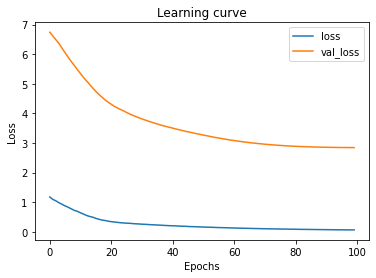

In [373]:
# learning curve
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Learning curve')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [374]:
mlp.save('mlp.h5')

In [375]:
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.67      0.80         3

    accuracy                           0.80         5
   macro avg       0.83      0.83      0.80         5
weighted avg       0.87      0.80      0.80         5



In [377]:
y_pred_mlp = mlp.predict(X_test) >= 0.5
print(classification_report(y_test, y_pred_mlp))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.67      0.67      0.67         3

    accuracy                           0.60         5
   macro avg       0.58      0.58      0.58         5
weighted avg       0.60      0.60      0.60         5



In [389]:
# try without PCA, because NN can do dimensionality reduction automatically
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=1)

mlp_full = tf.keras.Sequential()
mlp_full.add(layers.Dense(5, input_shape=(X_train.shape[1],), activation='relu'))
mlp_full.add(layers.Dense(5, activation='relu'))
mlp_full.add(layers.Dense(1, activation='sigmoid'))
mlp_full.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_107 (Dense)            (None, 5)                 72005     
_________________________________________________________________
dense_108 (Dense)            (None, 5)                 30        
_________________________________________________________________
dense_109 (Dense)            (None, 1)                 6         
Total params: 72,041
Trainable params: 72,041
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
3/3 [==============================] - 0s 37ms/step - loss: 0.5993 - accuracy: 0.8000 - val_loss: 0.5722 - val_accuracy: 0.6000
Epoch 2/50
3/3 [==============================] - 0s 12ms/step - loss: 0.5481 - accuracy: 0.8000 - val_loss: 0.4453 - val_accuracy: 0.6000
Epoch 3/50
3/3 [==============================] - 0s 12ms/step - loss: 0.2107 - accuracy: 0.8000 - val_loss: 0.4255 - val_accuracy: 0.6000
Epoch 4/50
3/3 [==============================] - 0s 10ms/step - loss: 0.0962 - accuracy: 0.9333 - val_loss: 0.4187 - val_accuracy: 0.6000
Epoch 5/50
3/3 [==============================] - 0s 10ms/step - loss: 0.0950 - accuracy: 0.9333 - val_loss: 0.4172 - val_accuracy: 0.6000
Epoch 6/50
3/3 [==============================] - 0s 11ms/step - loss: 0.0949 - accuracy: 0.9333 - val_loss: 0.4165 - val_accuracy: 0.8000
Epoch 7/50
3/3 [==============================] - 0s 11ms/step - loss: 0.0948 - accuracy: 0.9333 - val_loss: 0.4160 - val_accuracy: 0.8000
Epoch 8/50
3/3 [===========

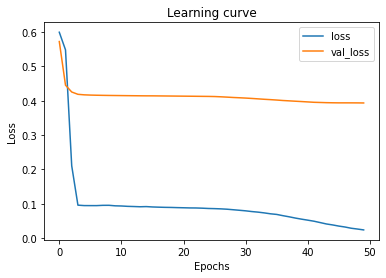

In [390]:
mlp_full.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
history = mlp_full.fit(X_train, y_train, batch_size=5, epochs=50,
                      validation_data=(X_test, y_test))
mlp_full.save('mlp_full.h5')

# learning curve
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Learning curve')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [391]:
y_pred_mlp = mlp_full.predict(X_test) >= 0.5
print(classification_report(y_test, y_pred_mlp))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.67      0.80         3

    accuracy                           0.80         5
   macro avg       0.83      0.83      0.80         5
weighted avg       0.87      0.80      0.80         5



In [392]:
# Continuous integration is enabled on this notebook
# store artifacts for CI testing

ci_artifacts = {
    'X' : X,
    'y' : y,
    'X_scaler' : scaler,
    'X_pca' : pca,
    'y_encoder' : le,
    'lr' : lr,
    'mlp_filename' : 'mlp_full.h5'
}

pickle.dump(ci_artifacts, open('ci_artifacts.pkl', 'wb'))